In [1]:
# Import Libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.cloud import storage
from sklearn.model_selection import train_test_split
from pathlib import Path

In [2]:
# Authenticate with GCP
from google.cloud import storage

# GCP Authentication and Key Setup
GCS_BUCKET = "yummy-secret-sauce"
GCS_KEY_PATH = "hairmatch-9da37740d8fa.json"
LOCAL_KEY_PATH = "/tmp/hairmatch-9da37740d8fa.json"

In [3]:
# Download the service account key from GCS
def download_key_from_gcs(bucket_name, blob_name, destination_path):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.download_to_filename(destination_path)
    print(f"Downloaded service account key to {destination_path}")

download_key_from_gcs(GCS_BUCKET, GCS_KEY_PATH, LOCAL_KEY_PATH)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = LOCAL_KEY_PATH
print(f"GOOGLE_APPLICATION_CREDENTIALS set to {LOCAL_KEY_PATH}")

# Set dataset GCS paths
DATASET_BUCKET = "hairtype-dataset"
DATASET_PATH = "data/"
LOCAL_DATASET_PATH = "/content/dataset/hairtype"

Downloaded service account key to /tmp/hairmatch-9da37740d8fa.json
GOOGLE_APPLICATION_CREDENTIALS set to /tmp/hairmatch-9da37740d8fa.json


In [12]:
# Helper function to download datasets from GCS
def download_files_from_gcs(bucket_name, source_path, destination_path):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=source_path)
    for blob in blobs:
        if not blob.name.endswith('/'):  # Skip directories
            relative_path = blob.name.replace(source_path, "")
            local_file_path = os.path.join(destination_path, relative_path)
            os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
            blob.download_to_filename(local_file_path)
            print(f"Downloaded {blob.name} to {local_file_path}")

# Download the dataset
download_files_from_gcs(DATASET_BUCKET, DATASET_PATH, LOCAL_DATASET_PATH)

Downloaded data/Straight/000028d73-Nicole_Scherzinger.jpg to /content/dataset/hairtype/Straight/000028d73-Nicole_Scherzinger.jpg
Downloaded data/Straight/01-10-2019-latest-haircut-for-girls_Equal_Length_4PNG.jpg to /content/dataset/hairtype/Straight/01-10-2019-latest-haircut-for-girls_Equal_Length_4PNG.jpg
Downloaded data/Straight/01-10-2019-latest-haircut-for-girls_short_pixie_straight_undercut_3PNG.jpg to /content/dataset/hairtype/Straight/01-10-2019-latest-haircut-for-girls_short_pixie_straight_undercut_3PNG.jpg
Downloaded data/Straight/01b8ef4743e2a5d1b3e888ef18acdfd0.jpg to /content/dataset/hairtype/Straight/01b8ef4743e2a5d1b3e888ef18acdfd0.jpg
Downloaded data/Straight/03e7316208c63582103294f3e1ef8b7b.jpg to /content/dataset/hairtype/Straight/03e7316208c63582103294f3e1ef8b7b.jpg
Downloaded data/Straight/051c0f399232bd22fb8ff55a6dde5441.jpg to /content/dataset/hairtype/Straight/051c0f399232bd22fb8ff55a6dde5441.jpg
Downloaded data/Straight/060c671d89cba47235d3a8a620bed080.jpg to /co

In [13]:
# Load the Pretrained Model from GCS
REFERENCE_BUCKET = "reference_models"
GCS_MODEL_PATH = "rcmalli_vggface_tf_notop_vgg16.h5"
PRETRAINED_MODEL_PATH = "/content/rcmalli_vggface_tf_notop_vgg16.h5"

# Download the model from GCS
def download_model(bucket_name, blob_name, destination_path):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.download_to_filename(destination_path)
    print(f"Model downloaded to {destination_path}")

download_model(REFERENCE_BUCKET, GCS_MODEL_PATH, PRETRAINED_MODEL_PATH)

Model downloaded to /content/rcmalli_vggface_tf_notop_vgg16.h5


In [14]:
# Dataset Split (90% Train, 10% Test)
all_data_dir = LOCAL_DATASET_PATH
train_dir = "/content/dataset/hairtype_train"
test_dir = "/content/dataset/hairtype_test"

def split_data(data_dir, train_dir, test_dir, split_ratio=0.1):
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        if not os.path.isdir(category_path):
            continue

        images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
        train_images, test_images = train_test_split(images, test_size=split_ratio, random_state=42)

        # Create directories
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Move images
        for img in train_images:
            os.rename(os.path.join(category_path, img), os.path.join(train_dir, category, img))
        for img in test_images:
            os.rename(os.path.join(category_path, img), os.path.join(test_dir, category, img))

split_data(all_data_dir, train_dir, test_dir)

In [15]:
# Model Creation
def create_hair_type_classifier(weights_path, input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights=None,
        input_shape=input_shape
    )

    base_model.load_weights(weights_path)

    for layer in base_model.layers:
        layer.trainable = False

    x = layers.Flatten()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.35)(x)
    x = layers.Dense(5, activation='softmax')(x)  # 5 hair types

    model = models.Model(inputs=base_model.input, outputs=x)
    return model

hair_type_model = create_hair_type_classifier(PRETRAINED_MODEL_PATH)

# Compile Model
hair_type_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
# Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data Generators
train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1788 images belonging to 5 classes.
Found 199 images belonging to 5 classes.


In [17]:
# Train the Model
history = hair_type_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 507ms/step - accuracy: 0.4110 - loss: 1.3857 - val_accuracy: 0.6633 - val_loss: 0.9550
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 475ms/step - accuracy: 0.6713 - loss: 0.9299 - val_accuracy: 0.6834 - val_loss: 0.8074
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 477ms/step - accuracy: 0.6971 - loss: 0.7986 - val_accuracy: 0.7035 - val_loss: 0.7618
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 472ms/step - accuracy: 0.7266 - loss: 0.7135 - val_accuracy: 0.6884 - val_loss: 0.7274
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 471ms/step - accuracy: 0.7320 - loss: 0.7068 - val_accuracy: 0.7437 - val_loss: 0.6737
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 472ms/step - accuracy: 0.7839 - loss: 0.6022 - val_accuracy: 0.7337 - val_loss: 0.6765
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 467ms/step - accuracy: 0.7900 - loss: 0.5999 - val_accuracy: 0.7487 - val_loss: 0.6551
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 466ms/step - accuracy: 0.7625 - loss: 0.6296 - val_accuracy: 0.788

In [18]:
# Save Model
SAVE_MODEL_PATH = "gs://hairtype-dataset/models/hair_type_classifier.h5"
hair_type_model.save(SAVE_MODEL_PATH)

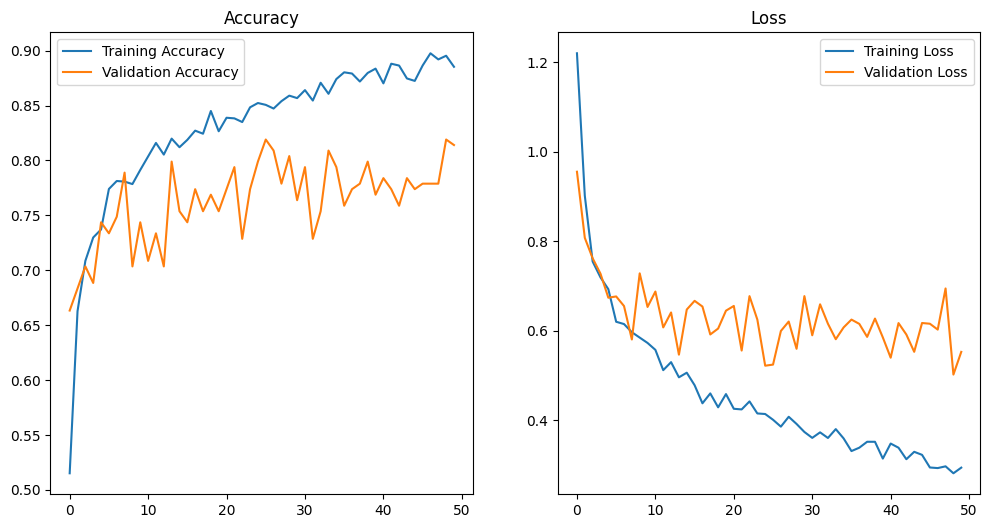

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - accuracy: 0.7964 - loss: 0.5741
Test Accuracy: 0.78, Test Loss: 0.65


In [19]:
# Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_training_history(history)

# Evaluate the Model
test_loss, test_acc = hair_type_model.evaluate(validation_generator)
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")

In [20]:
from google.colab import files
from tensorflow.keras.utils import img_to_array, load_img

def predict_image(image_path, model, class_mapping, target_size=(224, 224)):
    """
    Predict the class of an uploaded image.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): Trained model to use for prediction.
    - class_mapping (dict): Mapping from class indices to class names.
    - target_size (tuple): Target size to resize the image.

    Returns:
    - str: Predicted class name.
    """
    # Load and preprocess the image
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image) / 255.0  # Normalize to [0, 1]
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Predict the class
    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions[0])  # Get the index of the highest probability

    # Return the class name
    return class_mapping[predicted_index]

In [21]:
# Define class mapping
classes = {
    0: "Straight",
    1: "Wavy",
    2: "Curly",
    3: "Dreadlocks",
    4: "Kinky",
}

# Upload an image and predict the class
uploaded = files.upload()  # Upload an image
for file_name in uploaded.keys():
    predicted_class = predict_image(file_name, hair_type_model, classes)
    print(f"Predicted class for '{file_name}': {predicted_class}")

Saving 044cb72d389293289978d20b65344aff.jpg to 044cb72d389293289978d20b65344aff.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class for '044cb72d389293289978d20b65344aff.jpg': Straight
